In [1]:
import pickle as pkl
import random
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
from tqdm import tqdm

In [2]:
emb_path = "../output/embeddings/glove_dic_and_emb.pkl"
with open(emb_path, "rb") as f:
    word2id, id2word, embed, pca_embed, ica_embed = pkl.load(f)

def process_ica(vecs):
    """
    1. axis is sorted in descending order by the abs(skewness)
    2. skewness <- abs(skewness)
    """
    vecs = vecs[:, np.flip(np.argsort(np.abs(np.mean(vecs**3, axis=0))))]
    vecs = vecs * np.sign(scipy.stats.skew(vecs, axis=0))
    return vecs

def normalize(vecs):
    return vecs / np.linalg.norm(vecs, axis=1, keepdims=True)

ica_embed = process_ica(ica_embed)
ica_embed_norm1 = normalize(ica_embed)
n, dim = ica_embed.shape

pca_embed_norm1 = normalize(pca_embed)

dict_embed = {
    "ica": ica_embed,
    "pca": pca_embed,
    "ica_norm1": ica_embed_norm1,
    "pca_norm1": pca_embed_norm1
}

In [3]:
def topwords(name_embed, axis, n=5):
    global dict_embed
    emb = dict_embed[name_embed]
    sorted_idx = np.argsort(emb[:, axis])[::-1]
    topwords = [id2word[i] for i in sorted_idx[:n]]
    return topwords

In [4]:
def get_dict_intruder_candidates(vectype):
    """
    output: dict_intruder_candidates[ax] = [intruder candidates of axis=ax]
    """
    global dict_embed, id2word
    emb = dict_embed[vectype]
    dim = emb.shape[1]
    word_count = emb.shape[0]

    dict_lower_half = {}
    dict_top10p = {}
    print("2/3 : lower_half / top10p")
    for i in tqdm(range(dim)):
        sorted_indices = np.argsort(emb[:, i])[::-1]
        mid_point = word_count // 2
        top_10_percent = word_count // 10
        dict_lower_half[i] = set(id2word[wid] for wid in sorted_indices[mid_point:])
        dict_top10p[i] = set(id2word[wid] for wid in sorted_indices[:top_10_percent])

    dict_intruder_candidates = {}
    print("3/3 : candidates")
    for ax in tqdm(range(dim)):
        lower_half = dict_lower_half[ax]
        candidates = set()
        for i in range(dim):
            candidates.update(lower_half & dict_top10p[i])
        dict_intruder_candidates[ax] = list(candidates)
    return dict_intruder_candidates

def l2dist(vec1, vec2):
    return (np.linalg.norm(vec1 - vec2))

class Intruder:
    def __init__(self, top_n):
        global dim, topwords, get_dict_intruder_candidates
        self.dict_topwords = {
            "ica": {i: topwords("ica", i, n=top_n) for i in tqdm(range(dim))},
            "pca": {i: topwords("pca", i, n=top_n) for i in tqdm(range(dim))},
            "ica_norm1": {i: topwords("ica_norm1", i, n=top_n) for i in tqdm(range(dim))},
            "pca_norm1": {i: topwords("pca_norm1", i, n=top_n) for i in tqdm(range(dim))}
        }
        self.dict_intruder_candidates = {
            "ica": get_dict_intruder_candidates("ica"),
            "pca": get_dict_intruder_candidates("pca"),
            "ica_norm1": get_dict_intruder_candidates("ica_norm1"),
            "pca_norm1": get_dict_intruder_candidates("pca_norm1")
        }
        self.dim = dim
    
    def score(self, vectype, axis):
        return self._inter_dist(vectype, axis) / self._intra_dist(vectype, axis)
    
    def average_scores(self, vectype, n_runs=100):
        scores = []
        for i in tqdm(range(self.dim)):
            average_i = 0
            for _ in range(n_runs):
                average_i += self.score(vectype, i)
            scores.append(average_i / n_runs)
        return scores
    
    def _inter_dist(self, vectype, axis):
        global embed, word2id
        axis_words = self.dict_topwords[vectype][axis]
        intruder_kouho = self.dict_intruder_candidates[vectype][axis]
        intruder = random.choice(intruder_kouho)
        d = 0
        for w1 in axis_words:
            d += l2dist(embed[word2id[w1]], embed[word2id[intruder]])
        d /= len(axis_words)
        return d
    
    def _intra_dist(self, vectype, axis):
        global embed, word2id
        axis_words = self.dict_topwords[vectype][axis]
        d = 0
        for w1 in axis_words:
            for w2 in axis_words:
                if w1 != w2:
                    d += l2dist(embed[word2id[w1]], embed[word2id[w2]])
        d /= (len(axis_words) * (len(axis_words) - 1))
        return d

In [5]:
intruder_5_path = Path("../data/word_intruder_task/intruder_5.pkl")
if intruder_5_path.exists():
    with open(intruder_5_path, "rb") as f:
        intruder_5 = pkl.load(f)
else:
    intruder_5 = Intruder(5)
    with open(intruder_5_path, "wb") as f:
        pkl.dump(intruder_5, f)

In [6]:
seed = 0
random.seed(seed)
np.random.seed(seed)
scores_ica = intruder_5.average_scores("ica", n_runs=10)
scores_pca = intruder_5.average_scores("pca", n_runs=10)
scores_ica_norm1 = intruder_5.average_scores("ica_norm1", n_runs=10)
scores_pca_norm1 = intruder_5.average_scores("pca_norm1", n_runs=10)

100%|██████████| 300/300 [00:00<00:00, 710.41it/s]


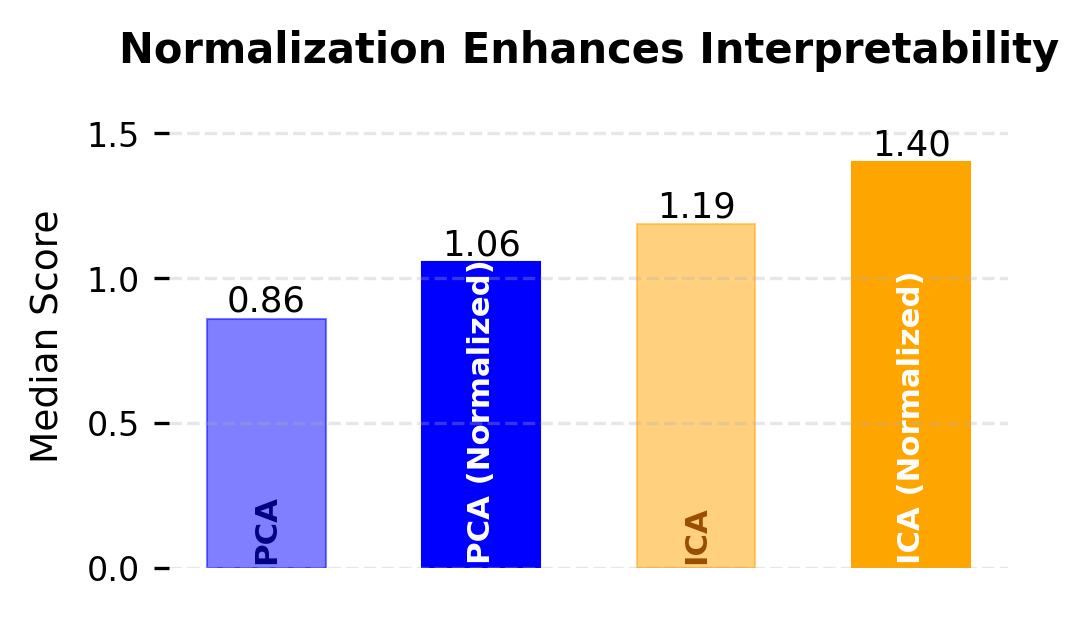

In [7]:
methods = ["PCA", "PCA (Normalized)", "ICA", "ICA (Normalized)"]
medians = [np.median(scores_pca), np.median(scores_pca_norm1), 
           np.median(scores_ica), np.median(scores_ica_norm1)]

colors_bar = ['blue','blue', 'orange', 'orange']
colors_text = ['#000080', 'white', '#994D00', 'white']
alphas = [0.5, 1, 0.5, 1]

plt.figure(figsize=(3.4, 2), dpi=300)

x = np.arange(len(methods))
width = 0.55

bars = plt.bar(x, medians, color=colors_bar, width=width, edgecolor='black', linewidth=0.5, bottom=0)
for bar, color, alpha in zip(bars, colors_bar, alphas):
    bar.set_color(color)
    bar.set_alpha(alpha)

plt.title("Normalization Enhances Interpretability", fontsize=10, fontweight='bold', pad=10)
plt.ylabel("Median Score", fontsize=9, labelpad=5)

plt.ylim(0, 1.6)
plt.grid(axis='y', linestyle='--', alpha=0.3)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}',
             ha='center', va='bottom', fontsize=8.5)

for bar, method, ct in zip(bars, methods, colors_text):
    plt.text(bar.get_x() + bar.get_width()/2, 0.015,
             method,
             ha='center', va='bottom', fontsize=7.4, color=ct,
             rotation=90, fontweight='bold')

plt.gca().set_facecolor('#f8f9fa')
plt.box(False)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.yticks(fontsize=8)
plt.tight_layout(pad=0.5)

output_dir = Path("../output/camera_ready_images")
output_dir.mkdir(exist_ok=True, parents=True)
output_path = output_dir / "intruder_bargraph.pdf"
plt.savefig(output_path, bbox_inches='tight', pad_inches=0.1)
plt.show()